# Kaggle - Mercari Price Suggestion Challenge

### 1. Description and Resources

Link: https://www.kaggle.com/c/mercari-price-suggestion-challenge

Can you automatically suggest product prices to online sellers?

### Resources:

* 

## 2. Python Libraries

In [56]:
# #Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import pandas_profiling

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time
import requests
import datetime
import math

import missingno as msno

# #sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn import preprocessing

# #Natural Language Processing
import gensim
from gensim import corpora

## 3. Dataset

In [2]:
!ls data/

sample_submission.csv
sample_submission.csv.7z
test.tsv
test.tsv.7z
train.tsv
train.tsv.7z


In [3]:
!head data/sample_submission.csv

test_id,price
0,26.738
1,26.738
2,26.738
3,26.738
4,26.738
5,26.738
6,26.738
7,26.738
8,26.738


In [4]:
!head data/test.tsv

test_id	name	item_condition_id	category_name	brand_name	shipping	item_description
0	"Breast cancer ""I fight like a girl"" ring"	1	Women/Jewelry/Rings		1	Size 7
1	"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers"	1	Other/Office supplies/Shipping Supplies		1	"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined with bubble wrap for protection Self Sealing (peel-and-seal), adhesive keeps contents secure and tamper proof Durable and lightweight Kraft material helps save on postage Approved by UPS, FedEx, and USPS."
2	Coach bag	1	Vintage & Collectibles/Bags and Purses/Handbag	Coach	1	Brand new coach bag. Bought for [rm] at a Coach outlet.
3	Floral Kimono	2	Women/Sweaters/Cardigan		0	-floral kimono -never worn -lightweight and perfect for hot weather
4	Life after Death	3	Other/Books/Religion & Spirituality		1	Rediscovering life after the loss of a loved one by Tony Cooke. Paperback in good condition 2003. â�¤ â�¤ Bundle and save! â�¤ â�¤ Book, death, grief, bereavement SHLF.SW.5.15
5	iPhone 6 Plus o

In [5]:
!head data/train.tsv

train_id	name	item_condition_id	category_name	brand_name	price	shipping	item_description
0	MLB Cincinnati Reds T Shirt Size XL	3	Men/Tops/T-shirts		10.0	1	No description yet
1	Razer BlackWidow Chroma Keyboard	3	Electronics/Computers & Tablets/Components & Parts	Razer	52.0	0	This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
2	AVA-VIV Blouse	1	Women/Tops & Blouses/Blouse	Target	10.0	1	Adorable top with a hint of lace and a key hole in the back! The pale pink is a 1X, and I also have a 3X available in white!
3	Leather Horse Statues	1	Home/Home DÃ©cor/Home DÃ©cor Accents		35.0	1	New with tags. Leather horses. Retail for [rm] each. Stand about a foot high. They are being sold as a pair. Any questions please ask. Free shipping. Just got out of storage
4	24K GOLD plated rose	1	Women/Jewelry/Necklaces		44.0	0	Complete with certificate of authenticity
5	Bund

In [6]:
df_input = pd.read_csv(filepath_or_buffer="data/train.tsv", sep="\t", )

In [7]:
df_test = pd.read_csv(filepath_or_buffer="data/test.tsv", sep="\t", )

In [8]:
df_input.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [9]:
print("Number of rows: ", df_input.shape[0])
print("Number of columns: ", df_input.shape[1])

Number of rows:  1482535
Number of columns:  8


In [10]:
df_input.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


### Data Dictionary

The files consist of a list of product listings. These files are tab-delimited.

* train_id or test_id - the id of the listing

* name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

* item_condition_id - the condition of the items provided by the seller

* category_name - category of the listing

* brand_name

* price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

* shipping - 1 if shipping fee is paid by seller and 0 by buyer

* item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

Please note that in stage 1, all the test data will be calculated on the public leaderboard. In stage 2, we will swap the test.tsv file to the complete test dataset that includes the private leaderboard data.

#### Are the train_ids unique?


In [11]:
print("Number of train_ids: ", len(df_input["train_id"]))
print("Number of unique train_ids: ", len(df_input["train_id"].unique()))

Number of train_ids:  1482535
Number of unique train_ids:  1482535


#### Distribution of item_condition_id

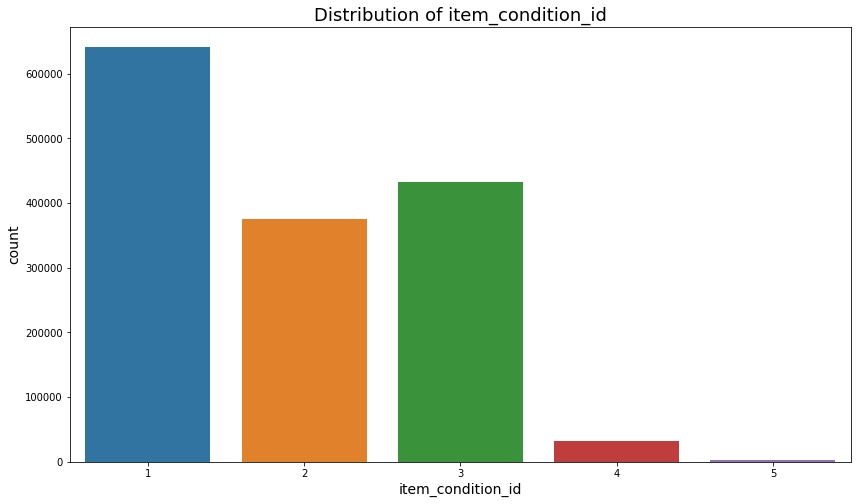

In [12]:
plt.figure(figsize=(14,8))
sns.countplot(df_input["item_condition_id"])

plt.xlabel('item_condition_id', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title("Distribution of item_condition_id", fontsize=18)
plt.show()


In [13]:
df_input.item_condition_id.value_counts()

1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64

#### Unique categories and their distribution

In [14]:
df_input.category_name.unique()

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse', ..., 'Handmade/Jewelry/Clothing',
       'Vintage & Collectibles/Supplies/Ephemera', 'Handmade/Pets/Blanket'], dtype=object)

In [15]:
# #Number of unique categories - 1288
len(df_input.category_name.unique())

1288

In [16]:
df_input.category_name.value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Tank, Cami                                20284
Women/Tops & Blouses/Blouse                                    20284
Women/Dresses/Above Knee, Mini                                 20082
Women/Jewelry/Necklaces                                        19758
Women/Athletic Apparel/Shorts                                  19528
Beauty/Makeup/Makeup Palettes                                  19103
Women/Shoes/Boots                 

#### Unique brands and their distribution

In [17]:
df_input.brand_name.unique()

array([nan, 'Razer', 'Target', ..., 'Astroglide', 'Cumberland Bay',
       'Kids Only'], dtype=object)

In [18]:
# #Number of unique brands - 4810
len(df_input.brand_name.unique())

4810

In [19]:
df_input.brand_name.value_counts()

PINK                                 54088
Nike                                 54043
Victoria's Secret                    48036
LuLaRoe                              31024
Apple                                17322
FOREVER 21                           15186
Nintendo                             15007
Lululemon                            14558
Michael Kors                         13928
American Eagle                       13254
Rae Dunn                             12305
Sephora                              12172
Coach                                10463
Disney                               10360
Bath & Body Works                    10354
Adidas                               10202
Funko                                 9237
Under Armour                          8461
Sony                                  7994
Old Navy                              7567
Hollister                             6948
Carter's                              6385
Urban Decay                           6210
The North F

### 4. Missing values

In [20]:
df_input.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [91]:
var_nan = float("nan")

df_input[df_input["category_name"] == np.nan]

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description


In [71]:
# #DATA CLEANING

### 5. Models

In [23]:
# #My Personal Model Leaderboard
var_sample_submission_benchmark = 0.82478
model_1_submission_1 = 0.65682

In [24]:
df_input.shape

(1482535, 8)

In [25]:
X = df_input.drop(["price"], axis=1)

In [26]:
X.shape

(1482535, 7)

In [27]:
y = df_input["price"]

In [28]:
y.shape

(1482535,)

In [29]:
# #Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [30]:
print("Train Dataset Shape - X_train: ", X_train.shape)
print("Train Dataset Shape - y_train: ", y_train.shape)
print("--------------------------------")
print("Test Dataset Shape - X_test: ", X_test.shape)
print("Test Dataset Shape - y_test: ", y_test.shape)

Train Dataset Shape - X_train:  (1037774, 7)
Train Dataset Shape - y_train:  (1037774,)
--------------------------------
Test Dataset Shape - X_test:  (444761, 7)
Test Dataset Shape - y_test:  (444761,)


### Model1: Baseline Median Model

In [31]:
df_input.shape

(1482535, 8)

In [32]:
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(df_input, df_input["price"], test_size=0.30, random_state=42)

In [33]:
print("Train Dataset Shape - X_train: ", X_train_baseline.shape)
print("Train Dataset Shape - y_train: ", y_train_baseline.shape)
print("--------------------------------")
print("Test Dataset Shape - X_test: ", X_test_baseline.shape)
print("Test Dataset Shape - y_test: ", y_test_baseline.shape)

Train Dataset Shape - X_train:  (1037774, 8)
Train Dataset Shape - y_train:  (1037774,)
--------------------------------
Test Dataset Shape - X_test:  (444761, 8)
Test Dataset Shape - y_test:  (444761,)


In [34]:
var_overall_median = X_train_baseline.price.median()
var_overall_median

17.0

In [35]:
df_input_price_category_median = X_train_baseline.groupby("category_name")["price"].median()
df_input_price_category_median

category_name
Beauty/Bath & Body/Bath                         14.0
Beauty/Bath & Body/Bathing Accessories          19.5
Beauty/Bath & Body/Cleansers                    10.0
Beauty/Bath & Body/Other                        16.0
Beauty/Bath & Body/Scrubs & Body Treatments     18.0
Beauty/Bath & Body/Sets                         18.0
Beauty/Fragrance/Candles & Home Scents          17.0
Beauty/Fragrance/Kids                            8.0
Beauty/Fragrance/Men                            23.0
Beauty/Fragrance/Other                          10.0
Beauty/Fragrance/Sets                           20.0
Beauty/Fragrance/Women                          18.0
Beauty/Hair Care/Conditioners                   16.0
Beauty/Hair Care/Hair & Scalp Treatments        14.0
Beauty/Hair Care/Hair Color                     10.0
Beauty/Hair Care/Hair Loss Products             16.0
Beauty/Hair Care/Hair Perms & Texturizers       12.5
Beauty/Hair Care/Hair Relaxers                   7.0
Beauty/Hair Care/Other          

In [36]:
# #Prediction Algo

arr_prediction = []
dict_price_category_median = df_input_price_category_median.to_dict()

for var_index, var_row in X_test_baseline.iterrows():
    if var_row["category_name"] not in dict_price_category_median.keys():
        arr_prediction.append(var_overall_median)
    else:
        arr_prediction.append(dict_price_category_median[var_row["category_name"]])

In [37]:
len(arr_prediction)

444761

In [38]:
pd.Series(arr_prediction[:10])

0     9.0
1    17.0
2    14.0
3     8.0
4    14.0
5    38.0
6    12.0
7    16.0
8    16.0
9    15.0
dtype: float64

In [39]:
y_test_baseline[:10]

777341      12.0
1463629     76.0
350669      12.0
310222       3.0
759257      30.0
288846     225.0
1178450     16.0
726296      12.0
840510      15.0
1473033     17.0
Name: price, dtype: float64

In [40]:
# #RMSLE
math.sqrt(mean_squared_log_error(y_test_baseline, pd.Series(arr_prediction)))

0.657873262321496

In [41]:
# #Make submission

In [42]:
var_overall_median = df_input.price.median()
df_input_price_category_median = df_input.groupby("category_name")["price"].median()

In [43]:
arr_prediction = []
dict_price_category_median = df_input_price_category_median.to_dict()

for var_index, var_row in df_test.iterrows():
    if var_row["category_name"] not in dict_price_category_median.keys():
        arr_prediction.append(var_overall_median)
    else:
        arr_prediction.append(dict_price_category_median[var_row["category_name"]])

In [44]:
df_model_1_submission = pd.DataFrame()
df_model_1_submission['test_id'] = df_test['test_id']
df_model_1_submission['price'] = pd.Series(arr_prediction)
df_model_1_submission.to_csv("submissions/model_1_submission_1.csv", index=False)

In [45]:
!head data/sample_submission.csv

test_id,price
0,26.738
1,26.738
2,26.738
3,26.738
4,26.738
5,26.738
6,26.738
7,26.738
8,26.738


In [46]:
!head submissions/model_1_submission_1.csv

test_id,price
0,15.0
1,9.0
2,55.0
3,17.0
4,11.0
5,10.0
6,12.0
7,32.0
8,18.0


In [47]:
# #Model 2
# #Random Forest Regressor

In [57]:
X_train[:10]

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description
1146412,1146412,Rue21 quarter sleeve,3,Women/Tops & Blouses/T-Shirts,rue,0,Quarter sleeve pink shirt. Stretchy material. ...
117583,117583,BCoppa77,2,Beauty/Bath & Body/Bath,NaN,1,No description yet
1242249,1242249,Baby Zara skinny jeans,3,Kids/Girls 0-24 Mos/Bottoms,NaN,1,Good condition Size 9-12 M
470404,470404,Jouer Skinny Dip Palette,1,Beauty/Makeup/Makeup Palettes,NaN,0,LE Skinny Dip Ultra Foil Shimmer Shadows Teste...
147937,147937,10k BLACK HILLS GOLD RING,3,Women/Jewelry/Rings,Stamped,0,Size 6 delicate heart BLACK HILLS GOLD RING. G...
548455,548455,Victoria secret sleep mask,2,Beauty/Skin Care/Eyes,Victoria's Secret,0,Sleep mask VS blocks out light to ensure a res...
1060084,1060084,Kendra Scott Drusy Ring,3,Women/Jewelry/Rings,Kendra Scott,0,Worn a few times. Approximately size 7 but adj...
2577,2577,liquid Lipstick Set for Christmas,1,Beauty/Makeup/Lips,NaN,1,FREE SHIPPING + BRAND NEW + CLEARANCE DON'T pu...
1120903,1120903,NWT LuLaRoe OS Christmas Cat,1,"Women/Athletic Apparel/Pants, Tights, Leggings",NaN,1,NWT LuLaRoe super cute OS leggings! These are ...
1274269,1274269,"Cute, Rustic Wall Clock",2,Home/Home Décor/Home Décor Accents,NaN,0,"In great shape! Moving, so looking for a good ..."


In [122]:
df_input.category_name = df_input.category_name.astype(str)
X_train.category_name = X_train.category_name.astype(str)
X_test.category_name = X_test.category_name.astype(str)

c:\users\karti\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [123]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df_input.category_name.unique())

LabelEncoder()

In [124]:
label_encoder.classes_

array(['Beauty/Bath & Body/Bath', 'Beauty/Bath & Body/Bathing Accessories',
       'Beauty/Bath & Body/Cleansers', ...,
       "Women/Women's Handbags/Shoulder Bag",
       "Women/Women's Handbags/Totes & Shoppers", 'nan'], dtype=object)

In [125]:
len(label_encoder.classes_)

1288

In [126]:
X_train["category_label_code"] = pd.DataFrame(label_encoder.transform(X_train["category_name"]))
X_test["category_label_code"] = pd.DataFrame(label_encoder.transform(X_test["category_name"]))

c:\users\karti\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\karti\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [127]:
X_train.head()

,train_id,name,item_condition_id,category_name,brand_name,shipping,item_description,category_label_code
1146412,1146412,Rue21 quarter sleeve,3,Women/Tops & Blouses/T-Shirts,rue,0,Quarter sleeve pink shirt. Stretchy material. ...,NaN
117583,117583,BCoppa77,2,Beauty/Bath & Body/Bath,NaN,1,No description yet,1144.0
1242249,1242249,Baby Zara skinny jeans,3,Kids/Girls 0-24 Mos/Bottoms,NaN,1,Good condition Size 9-12 M,NaN
470404,470404,Jouer Skinny Dip Palette,1,Beauty/Makeup/Makeup Palettes,NaN,0,LE Skinny Dip Ultra Foil Shimmer Shadows Teste...,197.0
147937,147937,10k BLACK HILLS GOLD RING,3,Women/Jewelry/Rings,Stamped,0,Size 6 delicate heart BLACK HILLS GOLD RING. G...,1137.0


In [128]:
X_train, X_test, y_train, y_test

(         train_id                                      name  \
 1146412   1146412                      Rue21 quarter sleeve   
 117583     117583                                  BCoppa77   
 1242249   1242249                    Baby Zara skinny jeans   
 470404     470404                  Jouer Skinny Dip Palette   
 147937     147937                 10k BLACK HILLS GOLD RING   
 548455     548455                Victoria secret sleep mask   
 1060084   1060084                   Kendra Scott Drusy Ring   
 2577         2577         liquid Lipstick Set for Christmas   
 1120903   1120903              NWT LuLaRoe OS Christmas Cat   
 1274269   1274269                   Cute, Rustic Wall Clock   
 963455     963455          Doc McSTUFFINS DOLL & Doc&Stuffy   
 339290     339290                             Lily Pulitzer   
 1327474   1327474                  Sonoline B fetal Doppler   
 51002       51002     New Urban Decay all nighter shade 3.5   
 669995     669995               Floral 

In [129]:
model_2 = RandomForestRegressor(max_depth=2, random_state=0)

In [130]:
X_train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'shipping', 'item_description', 'category_label_code'],
      dtype='object')

In [134]:
X_train[["item_condition_id", "shipping", "category_label_code"]]

,item_condition_id,shipping,category_label_code
1146412,3,0,NaN
117583,2,1,1144.0
1242249,3,1,NaN
470404,1,0,197.0
147937,3,0,1137.0
548455,2,0,108.0
1060084,3,0,NaN
2577,1,1,11.0
1120903,1,1,NaN
1274269,2,0,NaN


In [135]:
model_2.fit(X_train[["item_condition_id", "shipping", "category_label_code"]], y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
X, y = make_regression(n_features=4, n_informative=2,
...                        random_state=0, shuffle=False)
>>> 
>>> regr.fit(X, y)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
>>> print(regr.feature_importances_)
[ 0.17339552  0.81594114  0.          0.01066333]
>>> print(regr.predict([[0, 0, 0, 0]]))
[-2.50699856]

In [52]:
from gensim.models import Doc2Vec

In [ ]:
X_train.shape

In [ ]:
arr_item_descriptions = [var_word for var_item in X_train["item_description"][:10].tolist() for var_word in var_item.split()]

In [ ]:
dict_item_descriptions = corpora.Dictionary(arr_item_descriptions)

In [54]:
!pip install spacy

  Using cached spacy-2.0.5.tar.gz
  Using cached murmurhash-0.28.0.tar.gz
  Using cached cymem-1.31.2.tar.gz
  Using cached preshed-1.0.0.tar.gz
  Using cached thinc-6.10.2.tar.gz
  Using cached plac-0.9.6-py2.py3-none-any.whl
  Using cached pathlib-1.0.1.tar.gz
  Using cached ujson-1.35.tar.gz
  Using cached dill-0.2.7.1.tar.gz
  Using cached regex-2017.04.05-cp36-none-win_amd64.whl
  Using cached ftfy-4.4.3.tar.gz
  Using cached msgpack-python-0.4.8.tar.gz
  Using cached msgpack_numpy-0.4.1-py2.py3-none-any.whl
  Using cached wrapt-1.10.11.tar.gz
  Using cached tqdm-4.19.5-py2.py3-none-any.whl
  Using cached cytoolz-0.8.2.tar.gz
  Using cached termcolor-1.1.0.tar.gz
  Using cached pyreadline-2.1.zip
  Using cached toolz-0.9.0.tar.gz
  Running setup.py install for murmurhash: started
    Running setup.py install for murmurhash: finished with status 'done'
  Running setup.py install for cymem: started
    Running setup.py install for cymem: finished with status 'done'
  Running setup.p

In [55]:
!python -m spacy download en

  Running setup.py install for en-core-web-sm: started
    Running setup.py install for en-core-web-sm: finished with status 'done'

    Error: Couldn't link model to 'en'
    Creating a symlink in spacy/data failed. Make sure you have the required
    permissions and try re-running the command as admin, or use a
    virtualenv. You can still import the model as a module and call its
    load() method, or create the symlink manually.

    C:\Users\karti\AppData\Local\Programs\Python\Python36\lib\site-packages\en_core_web_sm
    -->
    C:\Users\karti\AppData\Local\Programs\Python\Python36\lib\site-packages\spacy\data\en


    Download successful
    Creating a shortcut link for 'en' didn't work (maybe you don't have
    admin permissions?), but you can still load the model via its full
    package name:

    nlp = spacy.load('en_core_web_sm')

